# Churn Prediction Project - Telco Customer Data
## Author: Erdem Tosun


# ======================================
# Section 1: Installing the Required Libraries
# ======================================

In [16]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn joblib


Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import joblib
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# ======================================
#  Section 2: Loading the Data Set and Initial Review
# ======================================

### This dataset contains customer information of a telecom company. The goal is to predict which customers will drop the service (churn).


In [18]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# ======================================
# Section 3: Data Cleaning and Preprocessing
# ======================================


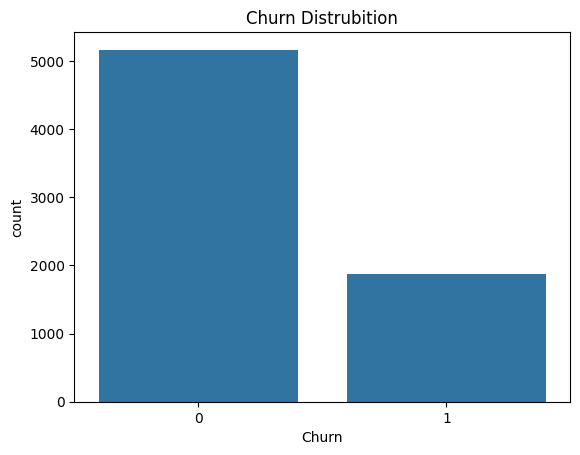

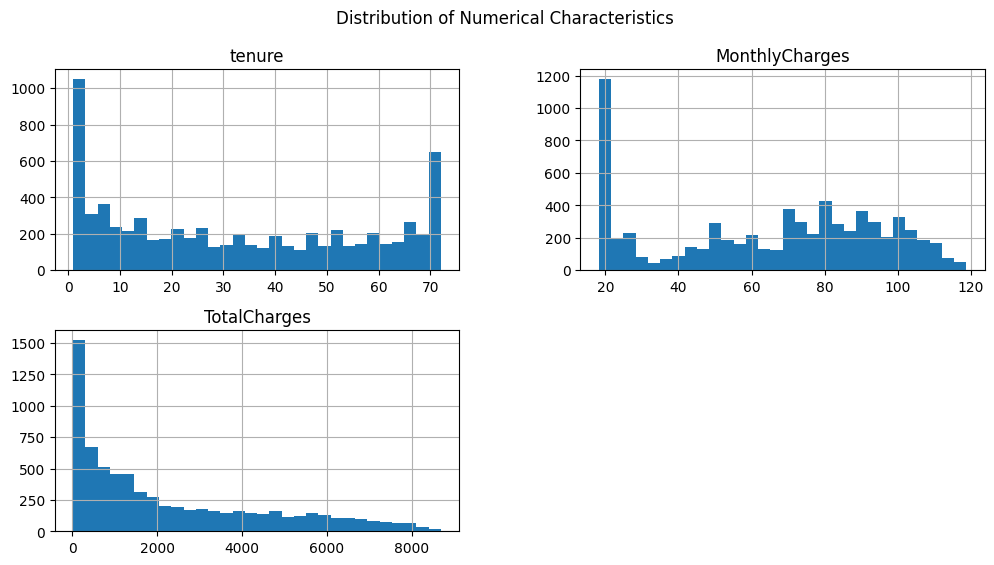

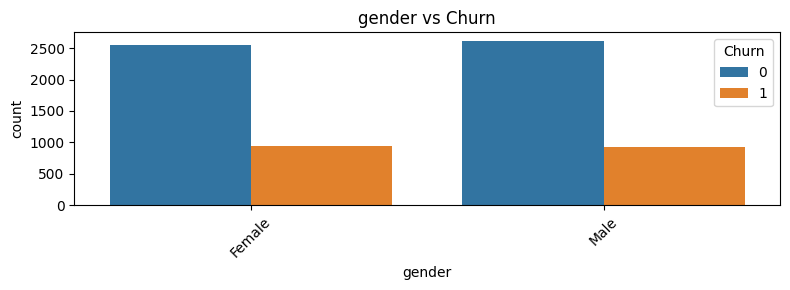

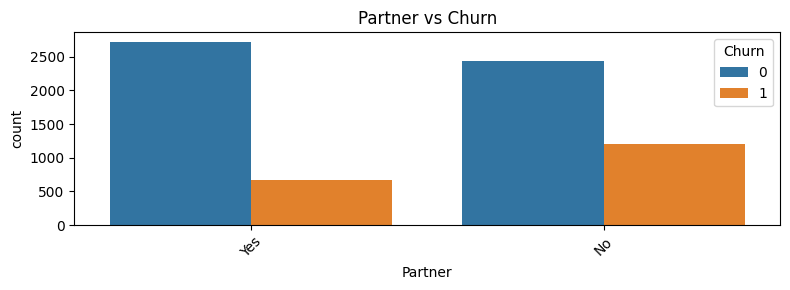

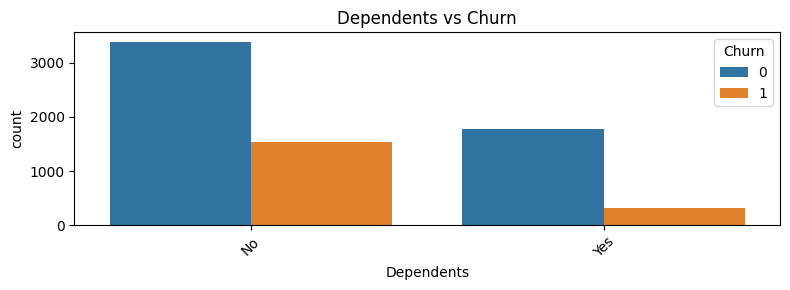

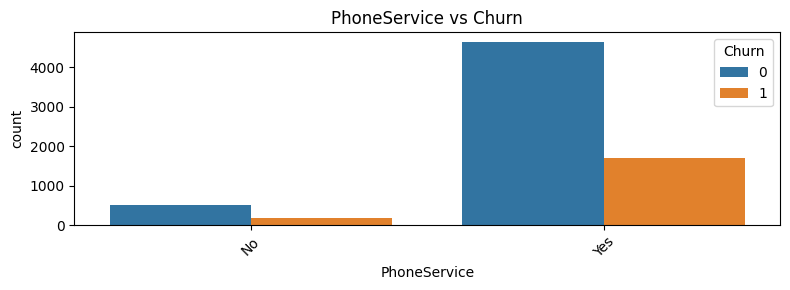

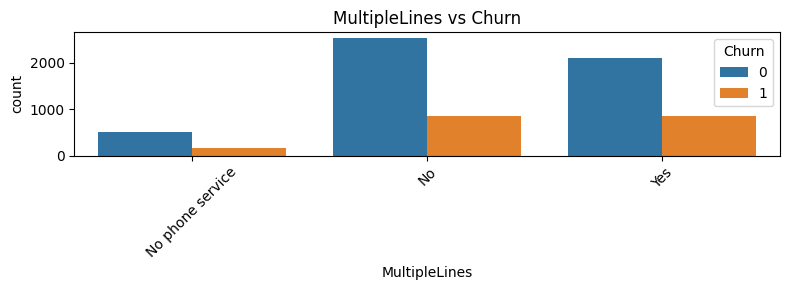

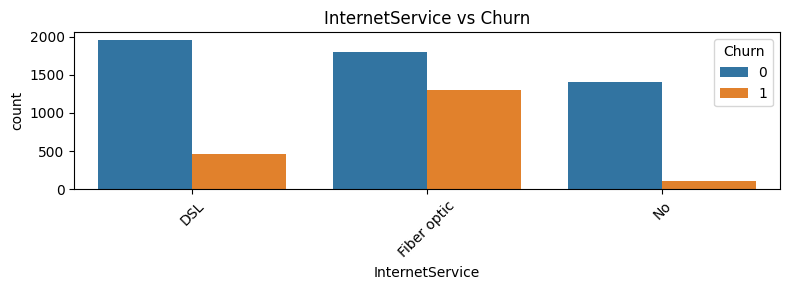

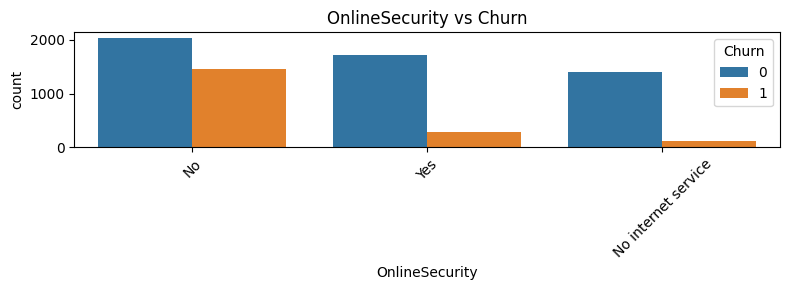

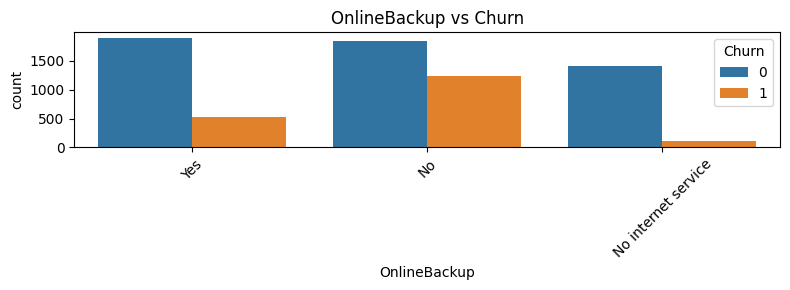

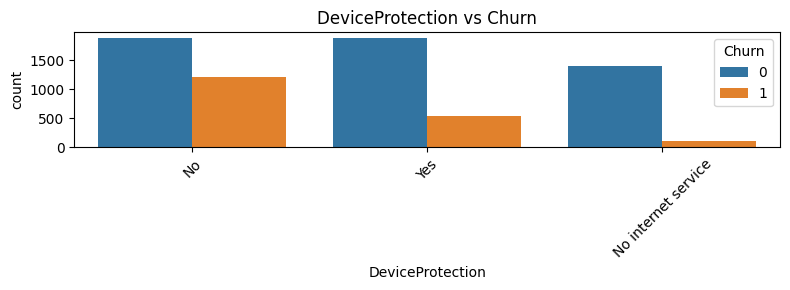

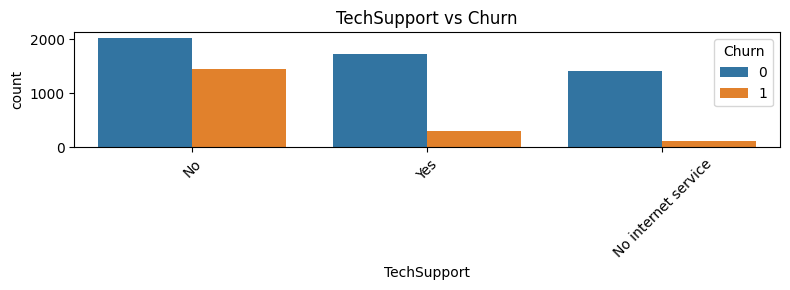

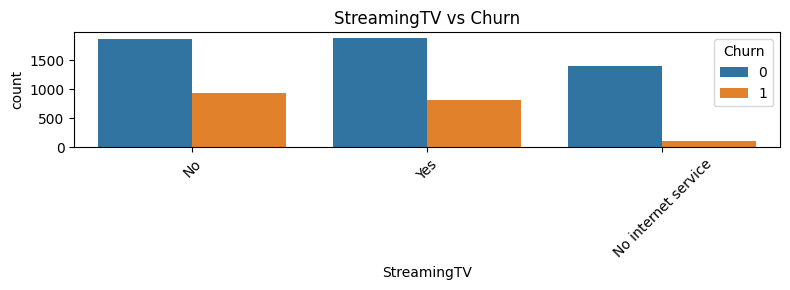

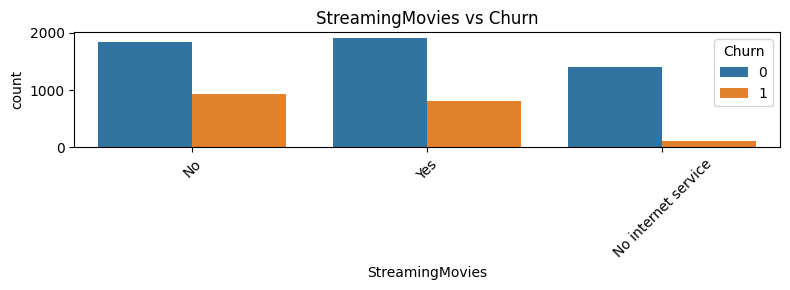

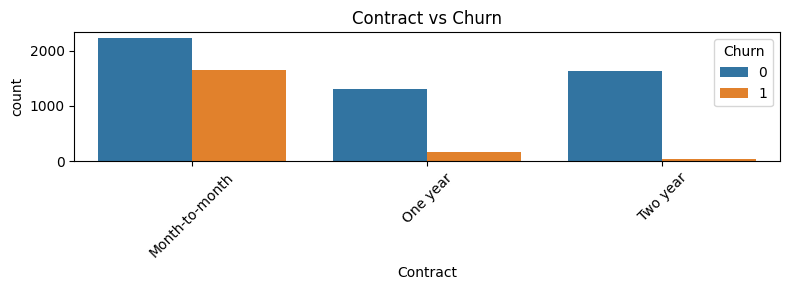

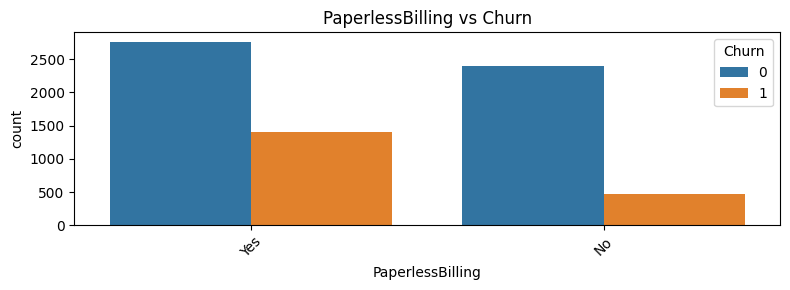

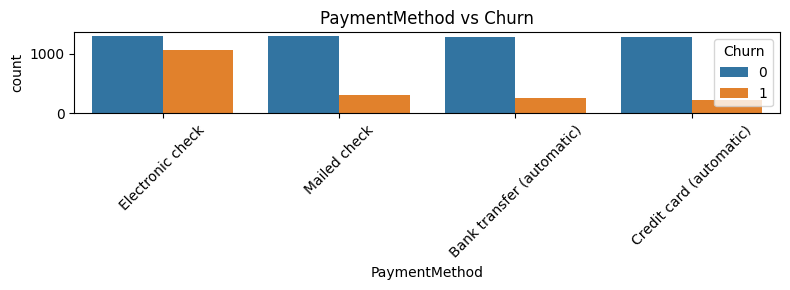

In [19]:
# TotalCharges must be numeric, but there are lines with spaces
# We clean these lines
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Convert target variable
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])  # Yes -> 1, No -> 0

# Churn rate
sns.countplot(x='Churn', data=df)
plt.title("Churn Distrubition")
plt.show()

# Distribution of numerical variables
df[['tenure', 'MonthlyCharges', 'TotalCharges']].hist(bins=30, figsize=(12,6))
plt.suptitle("Distribution of Numerical Characteristics")
plt.show()

# Relationship between categorical variables and churn
cat_cols = df.select_dtypes(include='object').columns.drop('customerID')
for col in cat_cols:
    plt.figure(figsize=(8,3))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
# 'customerID' unnecessary
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

# Let's label encode categorical variables
X = pd.get_dummies(X)

# Scale numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Restore class balance with SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


# ======================================
# 🤖 Bölüm 4: Model Training (XGBoost)
# ======================================

In [20]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1.0)
grid = GridSearchCV(xgb, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

model = grid.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


# ======================================
#  Section 5: Model Evaluation
# ======================================


In [21]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.8489835430784124
ROC-AUC: 0.9284022742586496

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      1037
           1       0.84      0.86      0.85      1029

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066



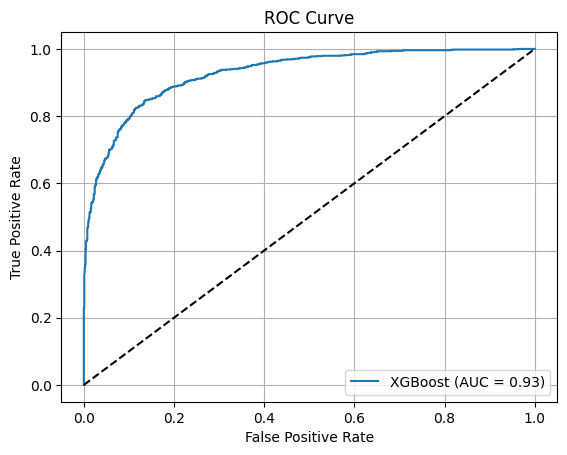

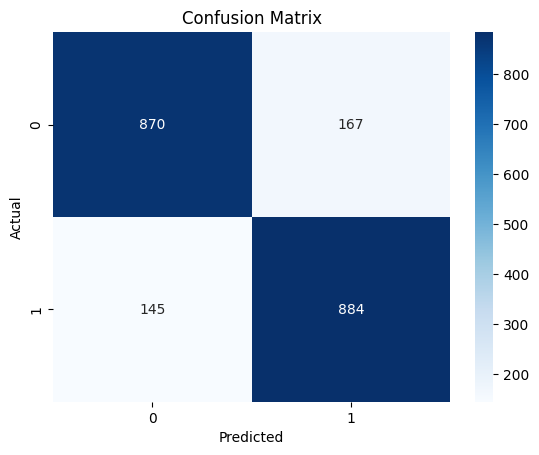

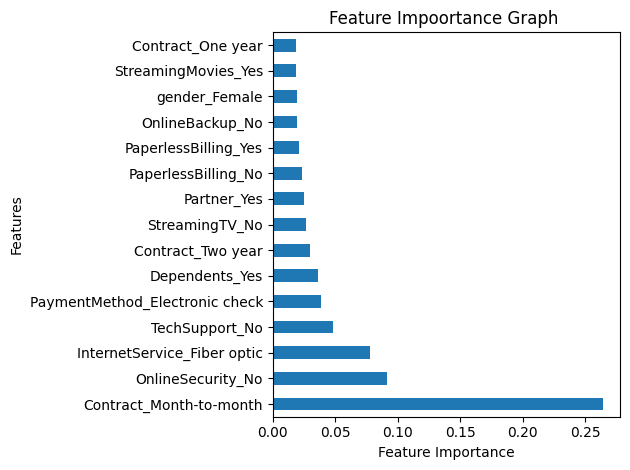

In [22]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='XGBoost (AUC = %.2f)' % roc_auc_score(y_test, y_proba))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(15).plot(kind='barh')
plt.title("Feature Impoortance Graph ")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


# ======================================
#  Section 6: Saving Model
# ======================================


In [24]:
joblib.dump(model, "models/churn_xgboost_model.pkl")
joblib.dump(scaler, "models/standard_scaler.pkl")


['models/standard_scaler.pkl']